# Non-Private Centralized Logistic Regression

In [1]:
# add files that we need!
import os
import sys
import logging 
logger = logging.getLogger()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.model.logistic_regression_models import MeanFieldMultiDimensionalLogisticRegression
from src.privacy_accounting.optimizer.standard_optimizer import StandardOptimizer
from src.privacy_accounting.analysis.moment_accountant import compute_privacy_loss_from_ledger


import torch
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

# plotting
%matplotlib inline

In [3]:
prior_params = {
    "w_nat_mean": np.array([0.0, 0.0], dtype=np.float32),
    "w_pres": np.array([0.1, 0.1], dtype=np.float32) 
}

# initally local likelihood is zero - init at the prior!
current_params = prior_params 

hyperparameters = {
    "n_in": 2,
    "N_samples": 50,
    "N_steps": 500,
    "base_optimizer_class": optim.SGD,
    "base_optimizer_parameters": {'lr': 0.02},
    "wrapped_optimizer_class": StandardOptimizer,
    "wrapped_optimizer_parameters": {},
}

logRegressionModel = MeanFieldMultiDimensionalLogisticRegression(current_params, hyperparameters)

In [4]:
data_x = np.array([[2, 2], [1, 1], [0, 1], [1, 0], [-0.5, 0.1], 
                       [-1, -1], [-2, -2], [0, -1], [-1, 0],
                       [0.5, 0.1]], dtype=np.float32)
data_y = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1, -1], dtype=np.float32)

def plot_results(data_x, data_y, opt_params):
    x_vals = data_x[:, 0]
    y_vals = data_x[:, 1]
    labels = data_y
    plt.figure()
    plt.grid(b=True)
    plt.scatter(x_vals, y_vals, c = labels)

    w_map = opt_params['w_nat_mean']/opt_params['w_pres']
    plt.arrow(0, 0, w_map[0], w_map[1], head_width=0.1)
    plt.plot([-2, 2], [(w_map[0]/w_map[1])*2, (w_map[0]/w_map[1])*-2])
    plt.show()
    
def plot_training(training_array):
    x_vals = np.arange(1, training_array.size+1)
    plt.figure()
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()
    
data = {
    "x": data_x,
    "y": data_y,
}

t = {
    "w_nat_mean": np.array([0, 0]),
    "w_pres": np.array([0, 0]) 
}


In [5]:
opt_params = logRegressionModel.fit(data, t, prior_params, hyperparameters)

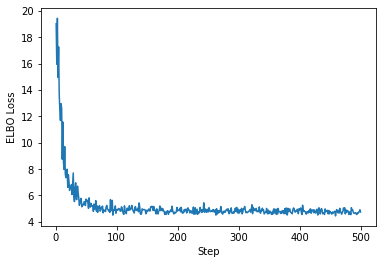

In [6]:
plot_training(logRegressionModel._training_curve)

{'w_nat_mean': array([0.81137365, 1.2841177 ], dtype=float32), 'w_pres': array([0.67999387, 0.40431926], dtype=float32)}


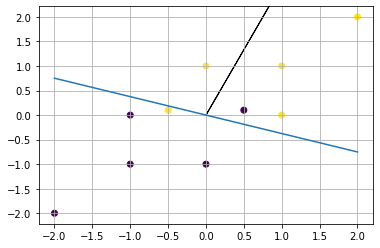

In [7]:
print(opt_params)
plot_results(data_x, data_y, opt_params)

## Let's use DP-SGD Instead!

In [8]:
from src.privacy_accounting.optimizer.dp_optimizer import DPGaussianOptimizer
from src.privacy_accounting.analysis import PrivacyLedger

ledger = PrivacyLedger(data_x.shape[0], 1)

hyperparameters = {
    "n_in": 2,
    "N_samples": 100,
    "N_steps": 1000,
    "base_optimizer_class": optim.SGD,
    "base_optimizer_parameters": {'lr': 0.01},
    "wrapped_optimizer_class": DPGaussianOptimizer,
    "wrapped_optimizer_parameters": {
                                     'l2_norm_clip':5.0,
                                     'noise_multiplier': 1,
                                     'num_microbatches': None,
                                     'ledger': ledger,
                                    }
}

logRegressionModel = MeanFieldMultiDimensionalLogisticRegression(current_params, hyperparameters)

/Users/msharma/workspace/DP-PVI/src/utils/torch_nest_utils.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  group_grads.append(operation(*ps))


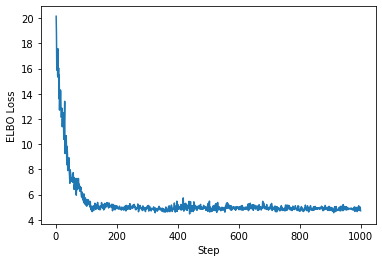

In [9]:
opt_params = logRegressionModel.fit(data, t, prior_params, hyperparameters)
plot_training(logRegressionModel._training_curve)

{'w_nat_mean': array([0.7616679, 1.2710305], dtype=float32), 'w_pres': array([0.60252976, 0.45983085], dtype=float32)}


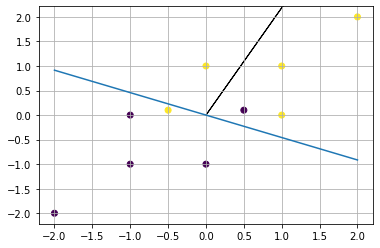

In [10]:
print(opt_params)
plot_results(data_x, data_y, opt_params)

In [11]:
import src.utils.numpy_nest_utils as np_nest
np_nest.structured_ndarrays_to_lists(logRegressionModel.log_update())

{'derived_statistics': [{'l2_norm:': [1.8046541213989258,
    0.8844382762908936,
    0.7221181988716125,
    0.7221181988716125,
    0.3230815529823303,
    1.018842339515686,
    2.077714443206787,
    0.8488014936447144,
    0.8488014936447144,
    0.3808137774467468]},
  {'l2_norm:': [1.8727741241455078,
    0.9262313842773438,
    0.7626631259918213,
    0.7790312170982361,
    0.35207903385162354,
    0.9070467352867126,
    1.869071125984192,
    0.7239580750465393,
    0.7369781136512756,
    0.33089160919189453]},
  {'l2_norm:': [1.5006728172302246,
    0.7413245439529419,
    0.5739465355873108,
    0.601269543170929,
    0.2803056836128235,
    0.9277969598770142,
    1.9370372295379639,
    0.7165358066558838,
    0.7523750066757202,
    0.342695951461792]},
  {'l2_norm:': [1.6638925075531006,
    0.8264310359954834,
    0.6605309247970581,
    0.6724145412445068,
    0.3127264678478241,
    0.9056139588356018,
    1.8746411800384521,
    0.7222598195075989,
    0.736383557

## How private are we?

Let's compute an $(\epsilon, \delta)$ guarantee. It is required that $\delta << \frac{1}{N} = 0.1$, let's choose $\delta = 10^{-3}$

In [12]:
eps, delta = compute_privacy_loss_from_ledger(ledger.get_formatted_ledger(), 1e-3)

In [13]:
print(eps)

1006.9077552789821


Given no optimisation has been performed for privacy performance, and the total lack of subsampling, this incredibly weak privacy guarantee is not so surpising. 